In [27]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

%matplotlib inline

PARTNER_ID="22"

In [28]:
#Extra functions helpers to make plots
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , size=4, aspect=2, **kwargs):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col, size = size, aspect = aspect  )
    facet.map( sns.barplot , cat , target, order=None )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 16 , 12 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print ( round(model.score(X, y) * 100, 2))

## Read Data

In [29]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = 'redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']

connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()




The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [30]:
# build the pandas dataframe with the bid information
query="select * from ml_prep.offer_load_eligibility_last_event_by_session_usd_with_offer_undersampled_" + PARTNER_ID
original_df = pd.read_sql_query(query, con)
original_df.head()

event_id            event_time  \
0  c8b0c850-a211-4e65-a825-96330fe44b5f  2018-02-20T19:31:41Z   
1  3dc06283-2a0d-4bc7-999c-0703eec1abea  2018-01-27T09:33:26Z   
2  4e40a04c-0d13-4c69-aa68-f6eebae21857  2017-12-12T22:11:26Z   
3  f3cb4010-4cab-46c2-b38f-867ce3ad7141  2018-02-22T18:14:47Z   
4  91563c1b-a265-4576-ac7d-860677bb82f8  2018-03-11T00:42:02Z   

                           request_id  partner_id origin destination  \
0  UFpCnQuf0vR8eP1YvZuIQdXypTBAZaowwc          22    NAN         AKL   
1  KXgHvsOP3ysum1wNZs4ba0SB9Z1cciPQKL          22    LAX         AKL   
2  v4iUZwt8EhQRWipm56xtvIt9KfPH8rH8Gk          22    AKL         ADL   
3  nyMUl0WTWwpxeyctAKVM9fTYRARUhvxsmi          22    LAX         AKL   
4  BpBJkh3dXeBdWOjIS95WlREqMvkKCor0cJ          22    AKL         SFO   

   flight_number departure_date departure_time currency     ...      \
0             51     2018-05-19          15:20      NZD     ...       
1              5     2018-02-11          21:40      NZD     ...       
2            191     2018-01-07          08:35      AUD     ...       
3              1     2018-03-07          20:55      USD     ...       
4              8     2018-03-15          19:45      USD     ...       

  slider_step duration  distance  distance_unit equipment slider_max_usd  \
0           5      190      1342             mi       772          440.0   
1           5      770      6523             mi       77W         1485.0   
2           5      275      2022             mi       789          416.0   
3           5      770      6523             mi       77W         2114.0   
4           5      725      6537             mi       77W         1470.0   

  slider_min_usd slider_start_usd offer_amount customer_id  
0           73.0            147.0     154.1399   4189281.0  
1          257.0            507.0     257.2500   3731292.0  
2           69.0            138.0      75.5629   3950903.0  
3          460.0            717.0     465.0000   4196231.0  
4          254.0            334.0     255.0000   4111321.0  

[5 rows x 33 columns]

In [31]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233209 entries, 0 to 233208
Data columns (total 33 columns):
event_id                              233209 non-null object
event_time                            233209 non-null object
request_id                            233209 non-null object
partner_id                            233209 non-null int64
origin                                233209 non-null object
destination                           233209 non-null object
flight_number                         233209 non-null int64
departure_date                        233209 non-null object
departure_time                        233209 non-null object
currency                              233209 non-null object
pnr                                   233209 non-null object
language                              233209 non-null object
pax                                   233209 non-null int64
eligibility                           233209 non-null bool
point_of_sale                         23

In [32]:
#drop non relevant fields
df = original_df.drop(['distance_unit', 'request_id', 'event_id', 'slider_step', 'pnr', 
         'instant_upgrade_eligibility_reason', 'eligibility_reason', "instant_upgrade_eligibility"
        ], axis=1)

In [33]:
# add has_bid based on the offer_amount column

df['has_bid'] = df['offer_amount'].notnull()
df.tail()

event_time  partner_id origin destination  flight_number  \
233204  2017-10-16T21:34:01Z          22    SFO         AKL              7   
233205  2018-02-22T00:32:48Z          22    LAX         AKL              5   
233206  2017-09-24T02:29:11Z          22    IAH         AKL             29   
233207  2017-12-16T17:46:26Z          22    SFO         AKL              7   
233208  2017-10-27T09:36:00Z          22    PER         AKL            176   

       departure_date departure_time currency language  pax   ...    \
233204     2017-10-28          20:45      NZD       en    1   ...     
233205     2018-02-25          21:40      USD       en    1   ...     
233206     2017-10-05          21:15      AUD       en    3   ...     
233207     2017-12-24          19:55      CAD       en    1   ...     
233208     2017-10-30          18:55      GBP       en    1   ...     

           upgrade_type duration distance equipment slider_max_usd  \
233204  PREMIUM_ECONOMY      770     6537       772         1451.0   
233205  PREMIUM_ECONOMY      770     6523       77W         1477.0   
233206  PREMIUM_ECONOMY      890     7430       772         1284.0   
233207  PREMIUM_ECONOMY      770     6537       77W         1413.0   
233208         BUSINESS      365     3320       789         1024.0   

       slider_min_usd slider_start_usd  offer_amount  customer_id has_bid  
233204          251.0            661.0      431.0431    3369004.0    True  
233205          256.0            504.0      600.0000    4193626.0    True  
233206          256.0            477.0      441.2623    3643272.0    True  
233207          245.0            644.0      287.5602    3965619.0    True  
233208          137.0            444.0      277.0207    3761121.0    True  

[5 rows x 26 columns]

In [34]:
#What is the distribution of numerical feature values across the samples?
df.describe()

partner_id  flight_number            pax       duration       distance  \
count    233209.0  233209.000000  233209.000000  233209.000000  233209.000000   
mean         22.0      72.833072       1.640438     576.684841    4870.757565   
std           0.0      84.971122       0.838920     221.329427    2039.538078   
min          22.0       1.000000       1.000000     170.000000    1247.000000   
25%          22.0       7.000000       1.000000     370.000000    3320.000000   
50%          22.0      29.000000       1.000000     650.000000    5496.000000   
75%          22.0     110.000000       2.000000     765.000000    6523.000000   
max          22.0     297.000000       9.000000     895.000000    7430.000000   

       slider_max_usd  slider_min_usd  slider_start_usd  offer_amount  \
count   233209.000000   233209.000000     233209.000000  46642.000000   
mean      1057.748753      193.442178        385.990751    297.027245   
std        462.329388       99.931345        184.732556    235.364045   
min        406.000000       67.000000        134.000000     67.974500   
25%        588.000000      108.000000        245.000000    125.000000   
50%       1176.000000      212.000000        333.000000    241.509500   
75%       1379.000000      252.000000        540.000000    400.000000   
max       2159.000000      471.000000        747.000000   2120.000000   

        customer_id  
count  4.664200e+04  
mean   3.641084e+06  
std    6.900793e+05  
min    1.733296e+06  
25%    3.685646e+06  
50%    3.877177e+06  
75%    4.085056e+06  
max    4.288211e+06

In [35]:
#What is the distribution of categorical feature values across the samples?
df.describe(include = ["O"])

event_time  origin destination departure_date  \
count                 233209  233209      233209         233209   
unique                156430      28          28            506   
top     2018-01-30T20:29:05Z     AKL         AKL     2018-03-09   
freq                       9  103169      105422           1662   

       departure_time currency language point_of_sale channel_source  \
count          233209   233209   233209        233209         233209   
unique            168       10        6            24             16   
top             20:55      NZD       en            NZ           ISIS   
freq            13490   119818   231490        119251         124288   

       carrier_code fare_class from_cabin     upgrade_type equipment  
count        233209     233209     233209           233209    233209  
unique            1         19          2                3         5  
top              NZ          S    ECONOMY  PREMIUM_ECONOMY       77W  
freq         233209      42920     196718           131436     90262

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233209 entries, 0 to 233208
Data columns (total 26 columns):
event_time          233209 non-null object
partner_id          233209 non-null int64
origin              233209 non-null object
destination         233209 non-null object
flight_number       233209 non-null int64
departure_date      233209 non-null object
departure_time      233209 non-null object
currency            233209 non-null object
language            233209 non-null object
pax                 233209 non-null int64
eligibility         233209 non-null bool
point_of_sale       233209 non-null object
channel_source      233209 non-null object
carrier_code        233209 non-null object
fare_class          233209 non-null object
from_cabin          233209 non-null object
upgrade_type        233209 non-null object
duration            233209 non-null int64
distance            233209 non-null int64
equipment           233209 non-null object
slider_max_usd      233209 non-null 

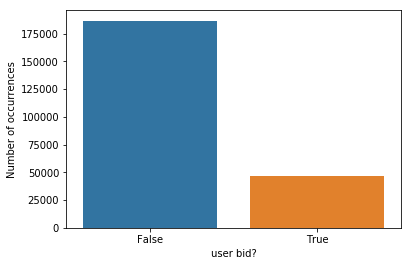

Has_bid percentage: 25.00%


In [37]:
#What is the distribution of has bid
sns.countplot(df.has_bid);
plt.xlabel('user bid?');
plt.ylabel('Number of occurrences');
plt.show()
has_bid_counts = df["has_bid"].value_counts().tolist()
print("Has_bid percentage: {0:.2f}%".format(has_bid_counts[1] / has_bid_counts[0] * 100))


## Conclusions about the original data

* missing data and unbalanced dataset


## Numerical analysis

## Visualization analysis

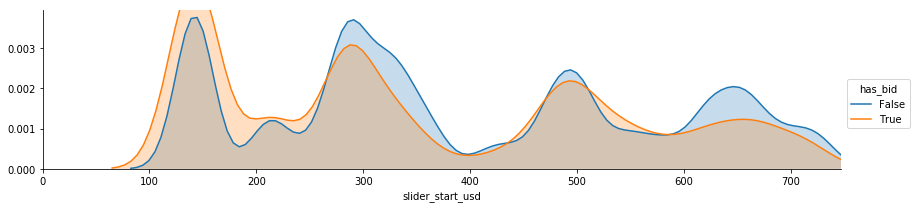

In [38]:
plot_distribution( df , var = 'slider_start_usd' , target = 'has_bid' )

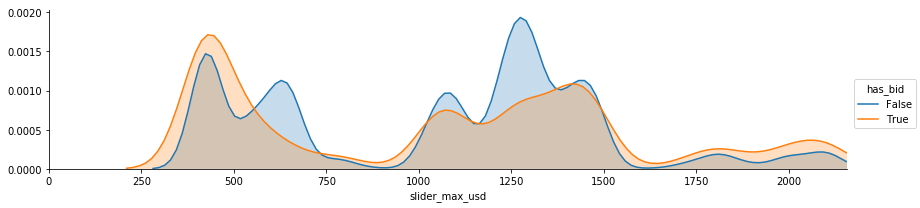

In [39]:
plot_distribution( df , var = 'slider_max_usd' , target = 'has_bid' )

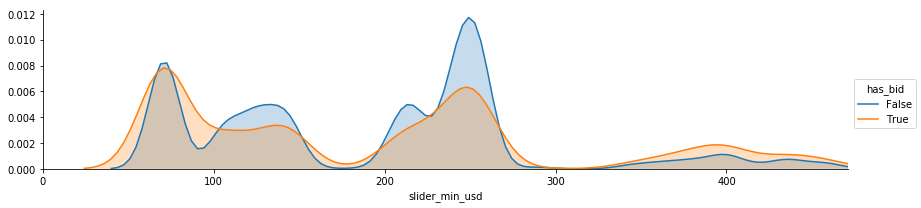

In [40]:
plot_distribution( df , var = 'slider_min_usd' , target = 'has_bid' )

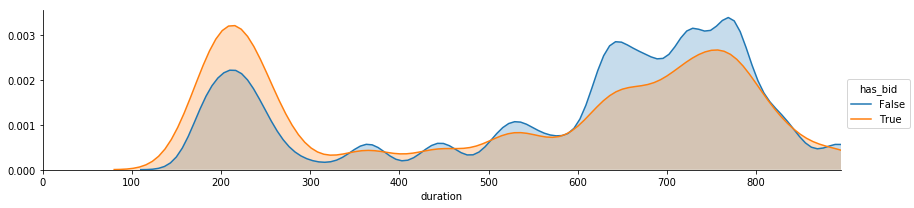

In [41]:
plot_distribution( df , var = 'duration' , target = 'has_bid' )

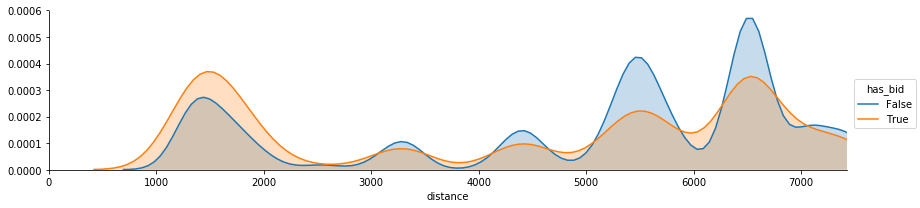

In [42]:
plot_distribution( df , var = 'distance' , target = 'has_bid' )

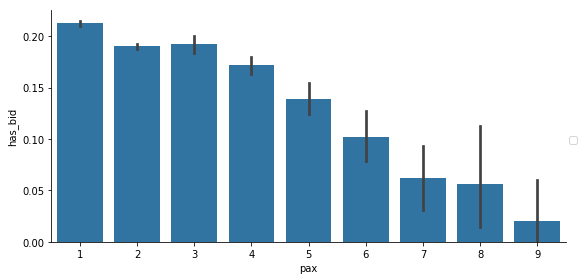

In [43]:
plot_categories( df , cat = 'pax' , target = 'has_bid' )

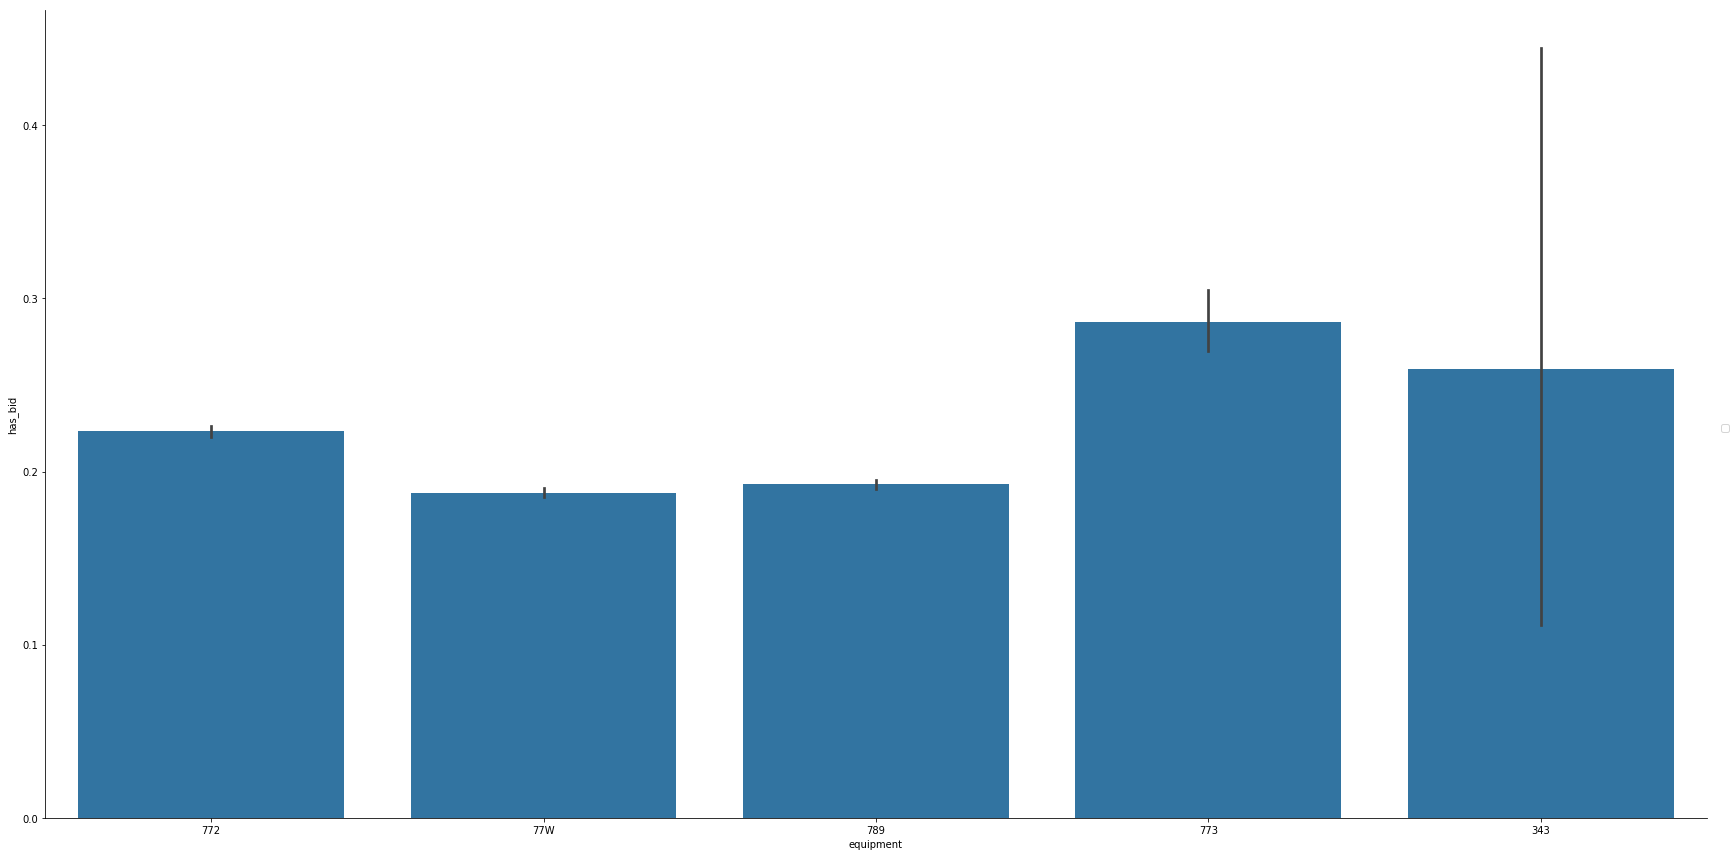

In [44]:
plot_categories( df , cat = 'equipment' , target = 'has_bid',size=12, aspect=2 )

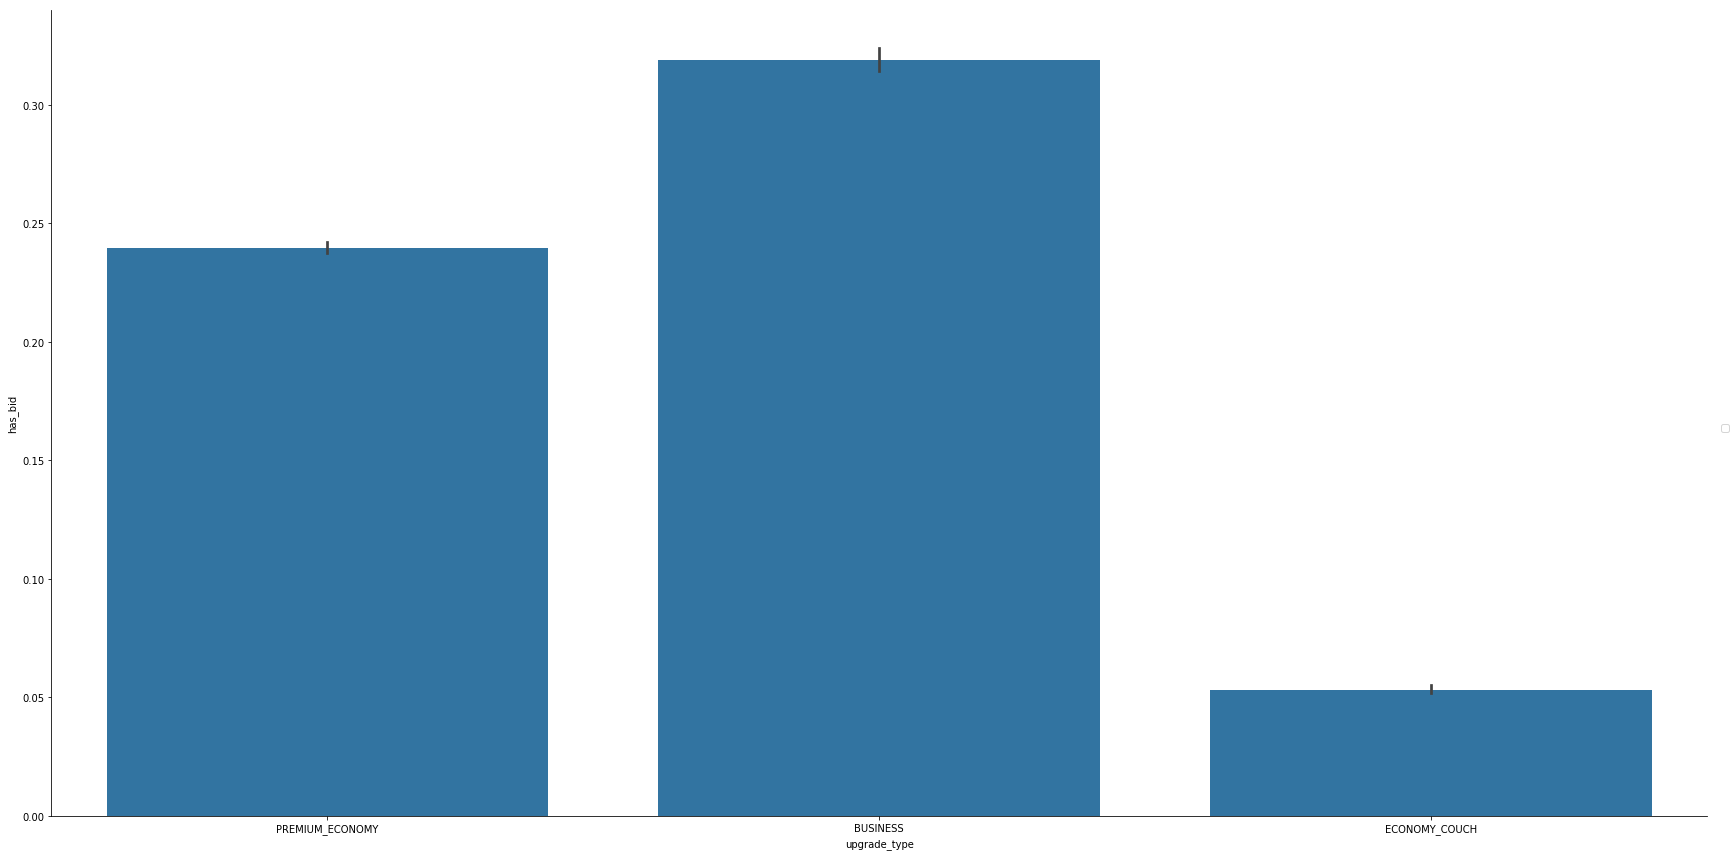

In [45]:
plot_categories( df , cat = 'upgrade_type' , target = 'has_bid',size=12, aspect=2 )

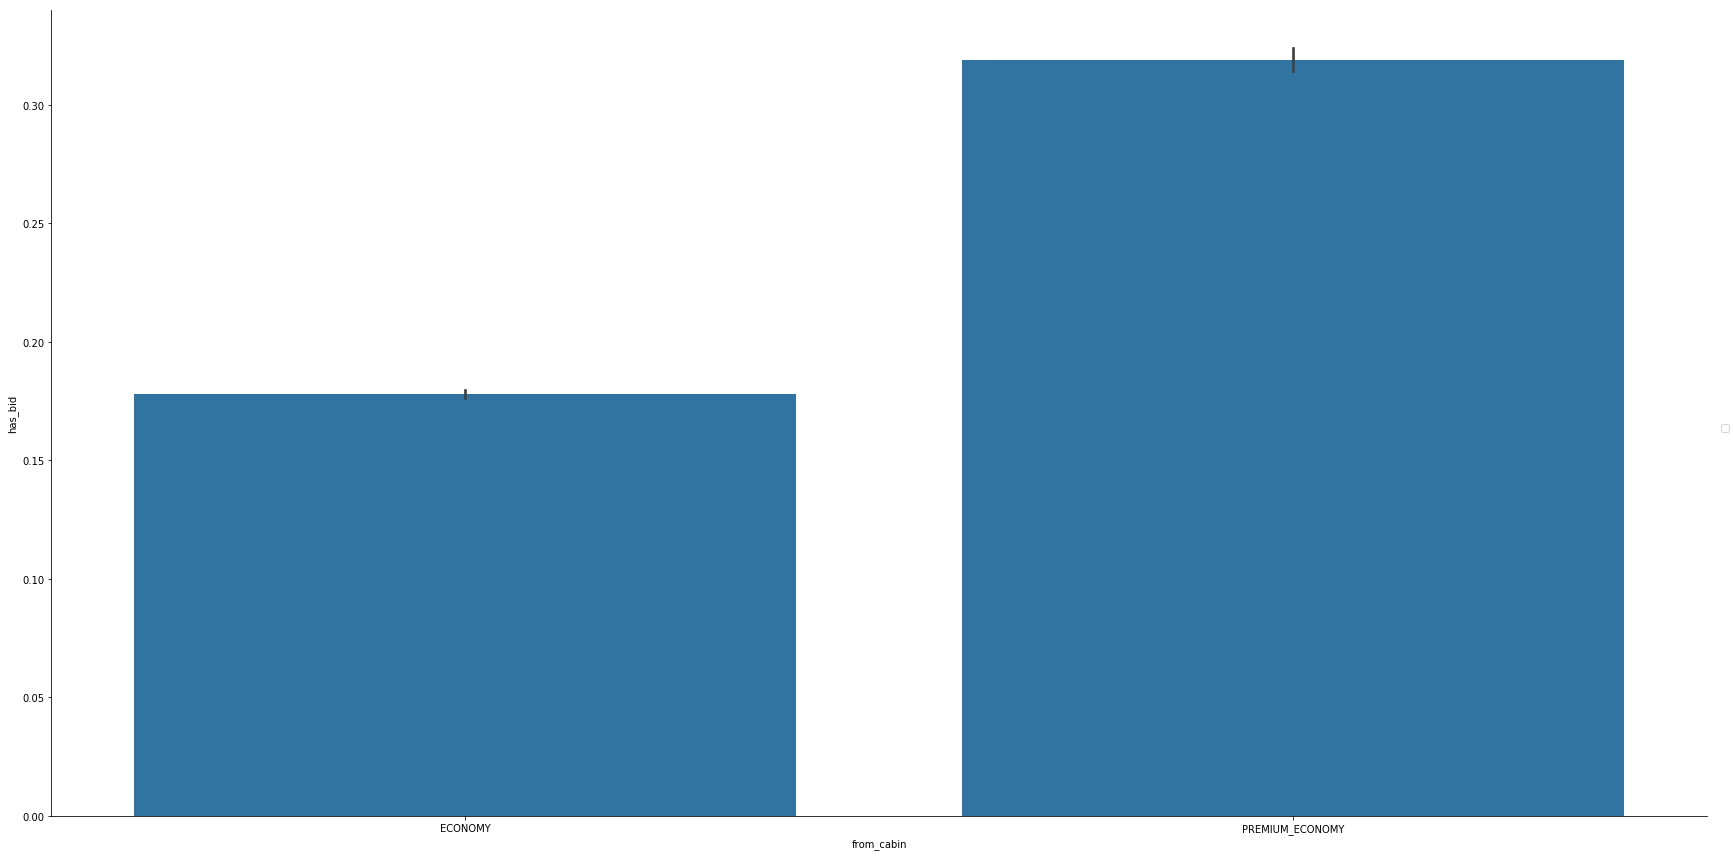

In [46]:
plot_categories( df , cat = 'from_cabin' , target = 'has_bid',size=12, aspect=2 )

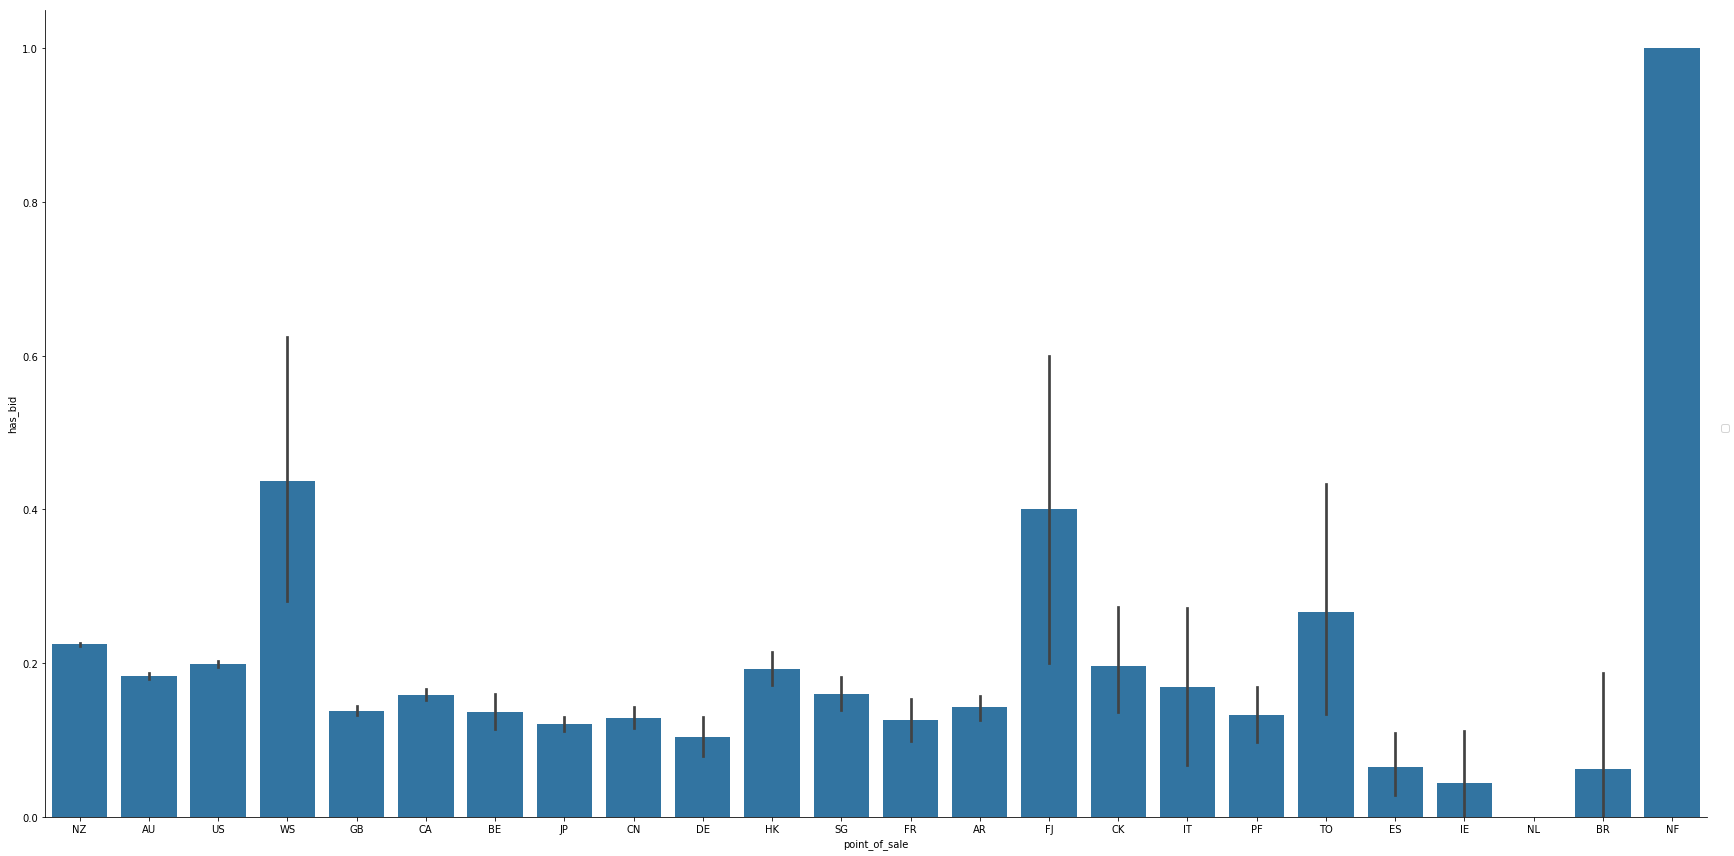

In [47]:
plot_categories( df , cat = 'point_of_sale' , target = 'has_bid',size=12, aspect=2 )

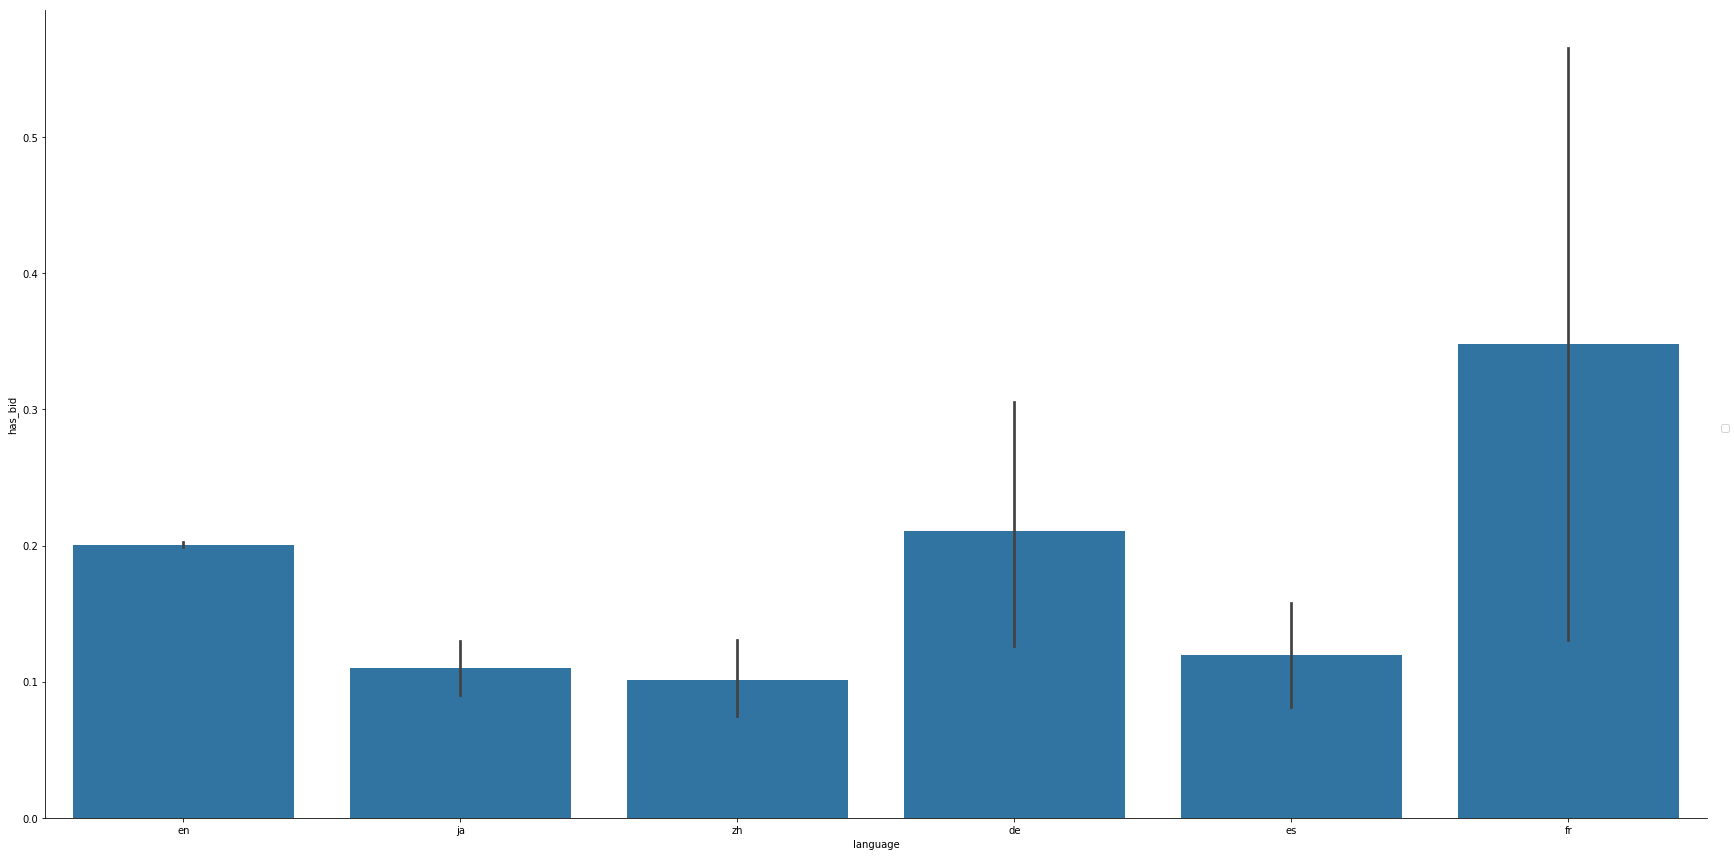

In [48]:
plot_categories( df , cat = 'language' , target = 'has_bid',size=12, aspect=2 )

## Wrangle Data

### Removing features fill nans

In [49]:
df_nonNas = df.copy()

#drop minutes from departure_time
df_nonNas["departure_time"] = df_nonNas.departure_time.apply(lambda x: str(x)[:-3] if len(str(x)) == 5  else x)

#fill equipment unknowns
df_nonNas['equipment'] = df_nonNas['equipment'].fillna("unknown")
df_nonNas['distance'] = df_nonNas['distance'].fillna(0)
df_nonNas['duration'] = df_nonNas['duration'].fillna(0)

df_nonNas['pax'] = df_nonNas['pax'].fillna(0)

#Convert float64 to float32
for column in ["pax", "slider_max_usd", "slider_min_usd", "slider_start_usd", "distance", "duration", "flight_number"]:
    df_nonNas[column] = df_nonNas[column].astype(np.float32)

train_df = df_nonNas.copy()


In [50]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233209 entries, 0 to 233208
Data columns (total 26 columns):
event_time          233209 non-null object
partner_id          233209 non-null int64
origin              233209 non-null object
destination         233209 non-null object
flight_number       233209 non-null float32
departure_date      233209 non-null object
departure_time      233209 non-null object
currency            233209 non-null object
language            233209 non-null object
pax                 233209 non-null float32
eligibility         233209 non-null bool
point_of_sale       233209 non-null object
channel_source      233209 non-null object
carrier_code        233209 non-null object
fare_class          233209 non-null object
from_cabin          233209 non-null object
upgrade_type        233209 non-null object
duration            233209 non-null float32
distance            233209 non-null float32
equipment           233209 non-null object
slider_max_usd      233209 n

### Prepare dataset

In [51]:
#we can factorize all values
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
leOrigin = preprocessing.LabelEncoder()
leDestination = preprocessing.LabelEncoder()
def factorize_df(df, columns):
    train_df_fact = df.copy()
    train_df_fact["channel_source"] = df[["channel_source"]].apply(lambda x: pd.factorize(x)[0])
    leDestination.fit(train_df_fact["destination"])
    train_df_fact["destination"] = leDestination.transform(train_df_fact["destination"])
    leOrigin.fit(train_df_fact["origin"])
    train_df_fact["origin"] = leOrigin.transform(train_df_fact["origin"])
    for column in columns:
        le.fit(train_df_fact[column])
        train_df_fact[column] = le.transform(train_df_fact[column])
    return train_df_fact
 

In [52]:
#factorize the categorical fields
columns_cat = ["equipment", "currency", "language", "fare_class", "departure_time", "upgrade_type", "from_cabin", "point_of_sale", "carrier_code", "flight_number"]  
train_df_fact = factorize_df(train_df, columns_cat) 

In [53]:
train_df_fact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233209 entries, 0 to 233208
Data columns (total 26 columns):
event_time          233209 non-null object
partner_id          233209 non-null int64
origin              233209 non-null int64
destination         233209 non-null int64
flight_number       233209 non-null int64
departure_date      233209 non-null object
departure_time      233209 non-null int64
currency            233209 non-null int64
language            233209 non-null int64
pax                 233209 non-null float32
eligibility         233209 non-null bool
point_of_sale       233209 non-null int64
channel_source      233209 non-null int64
carrier_code        233209 non-null int64
fare_class          233209 non-null int64
from_cabin          233209 non-null int64
upgrade_type        233209 non-null int64
duration            233209 non-null float32
distance            233209 non-null float32
equipment           233209 non-null int64
slider_max_usd      233209 non-null float3

## Create a model and evaluation

In [54]:
#Function utils
from sklearn.linear_model import LogisticRegression

random_forest = RandomForestClassifier(n_estimators=100)

def do_undersampling(df_to_undersampling, target, desiredRate=0.10):
    # Get the indices per target value
    idx_0 = df_to_undersampling[df_to_undersampling[target] == False].index
    idx_1 = df_to_undersampling[df_to_undersampling[target] == True].index

    # Get original number of records per target value
    nb_0 = len(df_to_undersampling.loc[idx_0])
    nb_1 = len(df_to_undersampling.loc[idx_1])

    # Calculate the undersampling rate and resulting number of records with target=0
    undersampling_rate = ((1-desiredRate)*nb_1)/(nb_0*desiredRate)
    undersampled_nb_0 = int(undersampling_rate*nb_0)
    print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
    print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

    # Randomly select records with target=0 to get at the desired a priori
    undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

    # Construct list with remaining indices
    idx_list = list(undersampled_idx) + list(idx_1)

    # Return undersample data frame
    return df_to_undersampling.loc[idx_list].reset_index(drop=True)

def do_train(df_to_train, n_splits = 5):
    kf = KFold(n_splits, random_state = 1, shuffle = True)
    x = df_to_train.drop("has_bid", axis=1)
    y = df_to_train["has_bid"]
    
    for i, (train_index, test_index) in enumerate(kf.split(df_to_train)):
        # Create data for this fold
        y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
        X_train, X_valid = x.iloc[train_index,:].copy(), x.iloc[test_index,:].copy()
        print( "\nFold ", i+1)
        random_forest.fit(X_train, y_train)
        acc_random_forest = round(random_forest.score(X_valid, y_valid) * 100, 2)
        print("Accuracy = {}".format(acc_random_forest))
        Y_test_pred = random_forest.predict_proba(X_valid)[:,1]
        fpr, tpr, _ = metrics.roc_curve(y_valid.astype(int), Y_test_pred)
        print("AUC = {}".format(metrics.auc(fpr, tpr)))

# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 

    return add_noise(ft_trn_series, noise_level)


In [56]:
origins = train_df_fact.origin.unique()
destinations = train_df_fact.destination.unique()

def getTestDatasetsByRoute(testDatasetsX, testDatasetsY):
    datasetsByRouteX = []
    datasetsByRouteY = []
    origins_labels = []
    destinations_labels = []
    for i in origins:
        for j in destinations:
            idx = (testDatasetsX['origin'] == i) & (testDatasetsX['destination'] == j)
            datasetsByRouteX.append(testDatasetsX.loc[idx].copy())
            datasetsByRouteY.append(testDatasetsY.loc[idx].copy())
            origins_labels.append(i)
            destinations_labels.append(j)
    return datasetsByRouteX, datasetsByRouteY, origins_labels, destinations_labels
    

def do_train_and_validate_by_route(df_to_train, n_splits = 2):
    kf = KFold(n_splits, random_state = 1, shuffle = True)
    x = df_to_train.drop("has_bid", axis=1)
    y = df_to_train["has_bid"]
    X_train, X_valid, y_train, y_valid = train_test_split(x,y, test_size=0.30, random_state=42)
    random_forest.fit(X_train, y_train)
    datasetsByRouteX, datasetsByRouteY, origins_labels, destinations_labels = getTestDatasetsByRoute(X_valid, y_valid)
    results = []
    for idx, val in enumerate(datasetsByRouteX):
        if (datasetsByRouteX[idx].shape[0] > 500):
            Y_test_pred = random_forest.predict_proba(datasetsByRouteX[idx])[:,1]
            fpr, tpr, _ = metrics.roc_curve(datasetsByRouteY[idx].astype(int), Y_test_pred)
            results.append([metrics.auc(fpr, tpr), leOrigin.inverse_transform(origins_labels[idx]), leDestination.inverse_transform(destinations_labels[idx])])
    results.sort(key=lambda x: x[0], reverse = True)
    for result in results:
        print("AUC = {}, ORIGIN = {}, DESTINATION = {}".format(result[0], result[1], result[2]))



### Feature engineering

In [57]:
#add days before departure and destination_origin
train_df2 = train_df.copy()
train_df2_020 = train_df2.copy()

train_df2_020["event_time"] = train_df2_020["event_time"].astype('datetime64[ns]')
train_df2_020["event_time"] = train_df2_020["event_time"].apply(lambda x: x.date() )
train_df2_020["departure_date"] = train_df2_020["departure_date"].astype('datetime64[ns]')
train_df2_020["departure_date"] = train_df2_020["departure_date"].apply(lambda x: x.date() )
train_df2_020["days_before_departure"] = train_df2_020["departure_date"] - train_df2_020["event_time"]
train_df2_020["days_before_departure"] = train_df2_020["days_before_departure"].apply(lambda x: x.days)
train_df2_020["destination_origin"] = train_df2_020["destination"]  + "-" + train_df2_020["origin"]

columns_cat2 = ["destination_origin", "origin", "destination", "equipment", "currency", "language", "fare_class", "departure_time", "upgrade_type", "from_cabin", "point_of_sale", "carrier_code", "flight_number"]


train_df_fact2 = factorize_df(train_df2_020, columns_cat2) 


In [58]:
train_df_fact2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233209 entries, 0 to 233208
Data columns (total 28 columns):
event_time               233209 non-null object
partner_id               233209 non-null int64
origin                   233209 non-null int64
destination              233209 non-null int64
flight_number            233209 non-null int64
departure_date           233209 non-null object
departure_time           233209 non-null int64
currency                 233209 non-null int64
language                 233209 non-null int64
pax                      233209 non-null float32
eligibility              233209 non-null bool
point_of_sale            233209 non-null int64
channel_source           233209 non-null int64
carrier_code             233209 non-null int64
fare_class               233209 non-null int64
from_cabin               233209 non-null int64
upgrade_type             233209 non-null int64
duration                 233209 non-null float32
distance                 233209 non-nu

In [59]:
train_df_3 = train_df_fact2.drop(["partner_id","eligibility", "departure_date","event_time", "language", "upgrade_type", "from_cabin", "point_of_sale", "customer_id", "offer_amount"], axis=1)

In [60]:
train_df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233209 entries, 0 to 233208
Data columns (total 18 columns):
origin                   233209 non-null int64
destination              233209 non-null int64
flight_number            233209 non-null int64
departure_time           233209 non-null int64
currency                 233209 non-null int64
pax                      233209 non-null float32
channel_source           233209 non-null int64
carrier_code             233209 non-null int64
fare_class               233209 non-null int64
duration                 233209 non-null float32
distance                 233209 non-null float32
equipment                233209 non-null int64
slider_max_usd           233209 non-null float32
slider_min_usd           233209 non-null float32
slider_start_usd         233209 non-null float32
has_bid                  233209 non-null bool
days_before_departure    233209 non-null int64
destination_origin       233209 non-null int64
dtypes: bool(1), float32(6), int

In [61]:
do_train_and_validate_by_route(train_df_3)

AUC = 0.7780434851210198, ORIGIN = LHR, DESTINATION = LAX
AUC = 0.7597577725627173, ORIGIN = LAX, DESTINATION = LHR
AUC = 0.7585819128787878, ORIGIN = EZE, DESTINATION = AKL
AUC = 0.7501779755283648, ORIGIN = PER, DESTINATION = AKL
AUC = 0.7472486295052645, ORIGIN = LAX, DESTINATION = AKL
AUC = 0.7432277606880533, ORIGIN = AKL, DESTINATION = YVR
AUC = 0.7427371283313996, ORIGIN = YVR, DESTINATION = AKL
AUC = 0.7396550821731392, ORIGIN = AKL, DESTINATION = PER
AUC = 0.7319994819994821, ORIGIN = AKL, DESTINATION = PVG
AUC = 0.729310157756374, ORIGIN = AKL, DESTINATION = LAX
AUC = 0.7288532025640596, ORIGIN = AKL, DESTINATION = EZE
AUC = 0.7273833495347868, ORIGIN = IAH, DESTINATION = AKL
AUC = 0.7245069402704404, ORIGIN = SFO, DESTINATION = AKL
AUC = 0.7224762860901475, ORIGIN = HKG, DESTINATION = AKL
AUC = 0.7211307972902554, ORIGIN = AKL, DESTINATION = HND
AUC = 0.7202136893543762, ORIGIN = AKL, DESTINATION = HKG
AUC = 0.719427068388331, ORIGIN = AKL, DESTINATION = SFO
AUC = 0.71056101